# In this notebook we will implement a simplified version of [Variational Inference with a Quantum Computer](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.16.044057)

The idea is to train a parameterised quantum circuit so that the distribution of its output (bitstrings) is close to some target distribution (which we can evaluate pointwise).

In [1]:
from jax import numpy as jnp, random, vmap, value_and_grad
from jax.lax import scan
import matplotlib.pyplot as plt
import optax

import qujax

In [2]:
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
stepsize = 1e-3
n_steps = 200
random_key = random.PRNGKey(0)

# Let's define the target distribution

We do this by fully specifying the probability mass function or PMF (in practice, for larger problems we would not store this as a fully specified array, rather a function that can be queried)

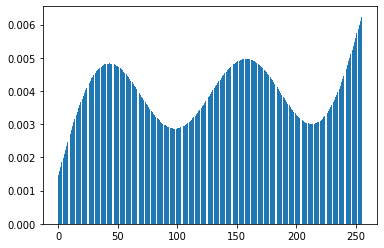

In [3]:
target_prob_func = (
    lambda x: 0.3 + x + 0.3 * jnp.sin(2 * jnp.pi * x) + 0.3 * jnp.sin(4 * jnp.pi * x)
)
target_pmf = target_prob_func(jnp.arange(2**n_qubits) / (2**n_qubits))
target_pmf /= target_pmf.sum()

plt.bar(jnp.arange(2**n_qubits), target_pmf);

# We will use the KL divergence as our training metric

We attempt to minimise
$$
    KL(p || q) = \sum_i \log \left( \frac{p_i}{q_i} \right) p_i,
$$
where $p$ is the distribution over the output of the quantum circuit (statetensor) and $q$ is the target distribution (which cannot contain zeroes).

In [4]:
def kl(p, q):
    return ((jnp.log(p) - jnp.log(q)) * p).sum()

# Now we can use `qujax` to generate a parameter to cost (KL) function

This begins with defining the quantum circuit

In [5]:
def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

In [6]:
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)

In [7]:
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=30);

q0: -----H-----Rx[0]---Ry[8]-----◯---------------------------------------------------
                                 |                                                   
q1: -----H-----Rx[1]---Ry[9]-----CZ------◯-------------------------------------------
                                         |                                           
q2: -----H-----Rx[2]---Ry[10]------------CZ------◯-----------------------------------
                                                 |                                   
q3: -----H-----Rx[3]---Ry[11]--------------------CZ------◯---------------------------
                                                         |                           
q4: -----H-----Rx[4]---Ry[12]----------------------------CZ------◯-------------------
                                                                 |                   
q5: -----H-----Rx[5]---Ry[13]------------------------------------CZ------◯-----------
                                                      

Then generating the parameter to statetensor function

In [8]:
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)

Before converting it into a parameter to KL function

In [9]:
def param_to_kl(param):
    st = param_to_st(param)
    p = jnp.square(jnp.abs(st.flatten()))
    return kl(p, target_pmf)

# Gradient descent time

[optax](https://github.com/deepmind/optax) provides a suite of gradient based JAX optimisers, we will use Adam

In [10]:
param_to_kl_and_grad = value_and_grad(param_to_kl)

In [11]:
optimiser = optax.adam(stepsize)

In [12]:
init_param = random.uniform(
    random_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)

In [13]:
init_opt_state = optimiser.init(init_param)

In [14]:
def gd_iteration(params_and_opt_state, step):
    params, opt_state = params_and_opt_state

    cost, grads = param_to_kl_and_grad(params)

    updates, new_opt_state = optimiser.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return (new_params, new_opt_state), (params, cost)

In [15]:
_, (params_path, cost_path) = scan(
    gd_iteration, (init_param, init_opt_state), jnp.arange(n_steps)
)

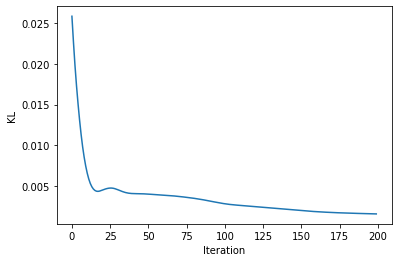

In [16]:
plt.plot(cost_path)
plt.xlabel("Iteration")
plt.ylabel("KL");

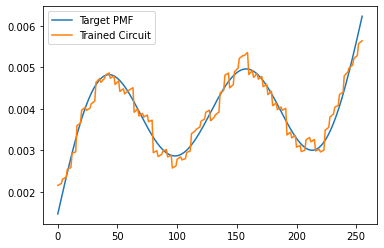

In [17]:
final_params = params_path[-1]
final_st = param_to_st(final_params)

plt.plot(target_pmf, label="Target PMF")
plt.plot(jnp.square(jnp.abs(final_st.flatten())), label="Trained Circuit")
plt.legend();

# Notes

The above variational inference algorithm is not practical to be run a quantum device for two reasons

- On a quantum device we do not have access to the full statetensor, only Monte Carlo samples from it. This is remedied by replacing the exact KL divergence and its gradients with Monte Carlo approximations.

- For samples from a quantum device we cannot evaluate the probability mass function $q$, which is required in the definition of the KL divergence.
This is remedied by either simultaneously training a classifier to approximate the KL divergence or by replacing the KL divergence with a Stein discrepancy - see [Variational Inference with a Quantum Computer](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.16.044057) for full details